## Table of Contents

1. [Creating a single cluster with pure feedforward connections](#1-pure-feedforward)
2. [Adding recurrency and self-excitation](#2-adding-recurrency-and-self-excitation)
3. [Adding negative feedback and creating a balanced EI](#adding-negative-feedback-via-inhibition)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd


sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
from bias_names import BIAS_NAMES

# Display plots inside Jupyter cell
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90


In [2]:
device_name = 'dynpase_test' # pick any name
model,no_gui = ut.open_dynapse1(gui=False, sender_port=19258, receiver_port=82457, select_device=True)

[0]:  Bus 1 Device 28 Dynapse1DevKit serial_number 00000001
[1]:  Bus 1 Device 23 Dynapse1DevKit serial_number 00000007
[2]:  Bus 1 Device 29 Dynapse1DevKit serial_number 00000027
[3]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000000
[4]:  Bus 1 Device 30 Dynapse1DevKit serial_number 00000020
[5]:  Bus 1 Device 26 Dynapse1DevKit serial_number 00000011
Sender port: tcp://0.0.0.0:19258
Receiver port: tcp://0.0.0.0:82457
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [3]:
def organize_results(events, df_spikes=None):
    # evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
    timestamp_offset = 0 
    if df_spikes is None:
        df_spikes = pd.DataFrame()
    for evt in events:
        if timestamp_offset==0:
            timestamp_offset = evt.timestamp
        spikeData = dict(chip = evt.chip_id, 
                        core = evt.core_id,
                        neuron_id = evt.neuron_id,
                        times =(evt.timestamp-timestamp_offset)* 1e-6)
        df_spikes = pd.concat([df_spikes,pd.DataFrame(spikeData,index=[0])])
    return df_spikes

## Encoding signals with population codes

By now, you should be convinced that silicon neurons, like biological neurons, are heterogenous. However, averaging the activity of a population of heterogenous neurons, we can reduce the effect of variability.

In this tutorial, we go through different connectivity schemes: feed-forward, recurrent excitation and feedback inhibition. The aim is to highlight how and why we can combine all of them to create an EI network, a very common computational primitive in the brain.

This exercise will be mostly hands-free (minimal skeleton code provided) to get you used to coding from scratch (as will happen with the projects).


 ### 1. Single Cluster with Pure Feedforward Connections
 
**Step 1**: Allocate a  population of 16 neurons in a single core.

**Step 2**: Stimulate the cluster with a Poisson train of 100 Hz via excitatory synapse (you might want to use NMDA with threshold set to 0).
**Step 3**: Set the network parameters to achive an average firing rate of 20 Hz.

**Step 4**: Sweep over the input frequency. Plot the following:
   - FF curve for the population activity but also for the individual neurons
    - Raster plot to show the neurons' spike times

In [10]:
emu_dur = 2 # in seconds
in_firing_rate = 100 # in hz

In [11]:
def generate_reg_sp_train(spikegen_gp, post_chip, rate, duration):
    # regular spike times
    spike_times = np.linspace(0, duration, duration * rate)
    # print(f"Spike times for a single spike generator ({len(spike_times)}):{spike_times}")

    # get global ids
    spgen_gids = ut.get_global_id_list(spikegen_gp.tuple_neuron_ids)

    # set spikegen ids global
    spike_ids = len(spike_times)* spgen_gids

    # set post chip
    # post_chip = DPI_neuron.chip_id
    target_chips = [post_chip]*len(spike_ids)

    return spike_times, spike_ids, target_chips
    

In [12]:
def pure_ff_bias():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    
    #------------------------AMPA parameters----------------------#
    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 7
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 255

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 0
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 0

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 0
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 0 

    #------------------------NMDA parameters----------------------#
    # first keep NMDA threshold to 0: i.e deactivate (AMPA_like) at coarse 0
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
    paramGroup.param_map["IF_NMDA_N"].fine_value = 0

    # Adjust weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 6 
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 100

    # # NMDA time constant
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80

    # NMDA gain
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 40

    #--------------------Neuron parameters--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    return paramGroup

In [17]:

# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

#-----------------------Network ----------------------------#
net_gen = n.NetworkGenerator()
# Allocate neurons of excitatory cluster
neu_chip_id = 0
neu_core_id = 1
n_exc = 16
neu_ids = np.arange(16, 16 + n_exc,1)

DPI_neuron =  n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Allocate spikegen
spgen_chip_id = 0
spgen_core_id = 1
spgen_id = [0]
spikegen = n.NeuronGroup(spgen_chip_id ,spgen_core_id,spgen_id,True) 


# Connect all2all with AMPA synpase
syn = n.Synapses(spikegen, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')
n.add_synapses(net_gen, syn)

print(f"Sanity check config:{net_gen.network}")

# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

#--------------------Set input spike train ----------------------#

# get FPGA spike_gen from model
fpga_spike_gen = model.get_fpga_spike_gen()
# # regular spike times
# spike_times = np.linspace(0, emu_dur, emu_dur *in_firing_rate)
# # print(f"Spike times for a single spike generator ({len(spike_times)}):{spike_times}")

# # get global ids
# spgen_gids = ut.get_global_id_list(spikegen.tuple_neuron_ids)

# # set spikegen ids global
# device_indices = len(spike_times)* spgen_gids

# # set post chip
# post_chip = DPI_neuron.chip_id
# target_chips = [post_chip]*len(device_indices)

isi_base = 900
repeat_mode = False
# spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, DPI_neuron.chip_id, in_firing_rate, emu_dur)
# ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)

#-----------------Tune biases-------------------------------------#
paramGroup = pure_ff_bias()
model.update_parameter_group(paramGroup, DPI_neuron.chip_id, DPI_neuron.core_id)


#--------------------Monitor ----------------------#

graph, filter_node, sink_node = ut.create_neuron_select_graph(model, DPI_neuron.tuple_neuron_ids)


results_df = pd.DataFrame()
ff_df = pd.DataFrame(columns=['in_rate', 'out_rate'])
mon_dur = 10 # in sec

in_rates = np.arange(10,400,20)
for row, rate in enumerate(in_rates):#range(10, 400, 50)
    spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, DPI_neuron.chip_id, rate, emu_dur)
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)
    
    # start gens
    fpga_spike_gen.start()

    # Start graph 
    graph.start()

    # Clear buffer
    sink_node.get_events()
    # for i in range(2):
    #     # get spikes every 2 seconds
    time.sleep(emu_dur)
    events = sink_node.get_events()

    #     # process the events
    mean_rate_pop = len(events)/n_exc/(emu_dur)
    #     print(f"Events:{len(events)}    Mean rate:{mean_rate_pop} Hz")
    #     results_df = organize_results(events, results_df)

    graph.stop()
    fpga_spike_gen.stop()

    # Organize events
    # results_df = organize_results(events, results_df)
    ff_df.loc[row] = [rate, mean_rate_pop]


Sanity check config:Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n31: [('C0c1s0', 'NMDA')]
C0c1n16: [('C0c1s0', 'NMDA')]
C0c1n17: [('C0c1s0', 'NMDA')]
C0c1n24: [('C0c1s0', 'NMDA')]
C0c1n29: [('C0c1s0', 'NMDA')]
C0c1n19: [('C0c1s0', 'NMDA')]
C0c1n18: [('C0c1s0', 'NMDA')]
C0c1n21: [('C0c1s0', 'NMDA')]
C0c1n25: [('C0c1s0', 'NMDA')]
C0c1n23: [('C0c1s0', 'NMDA')]
C0c1n22: [('C0c1s0', 'NMDA')]
C0c1n28: [('C0c1s0', 'NMDA')]
C0c1n27: [('C0c1s0', 'NMDA')]
C0c1n26: [('C0c1s0', 'NMDA')]
C0c1n30: [('C0c1s0', 'NMDA')]
C0c1n20: [('C0c1s0', 'NMDA')]



In [14]:
results_df

,chip,core,neuron_id,times
0,0,1,20,0.000000
0,0,1,21,0.002804
0,0,1,29,0.004782
0,0,1,26,0.004932
0,0,1,27,0.005042
...,...,...,...,...
0,0,1,24,2.015481
0,0,1,25,2.015871
0,0,1,16,2.016755
0,0,1,22,2.017411


(0.0, 4.0)

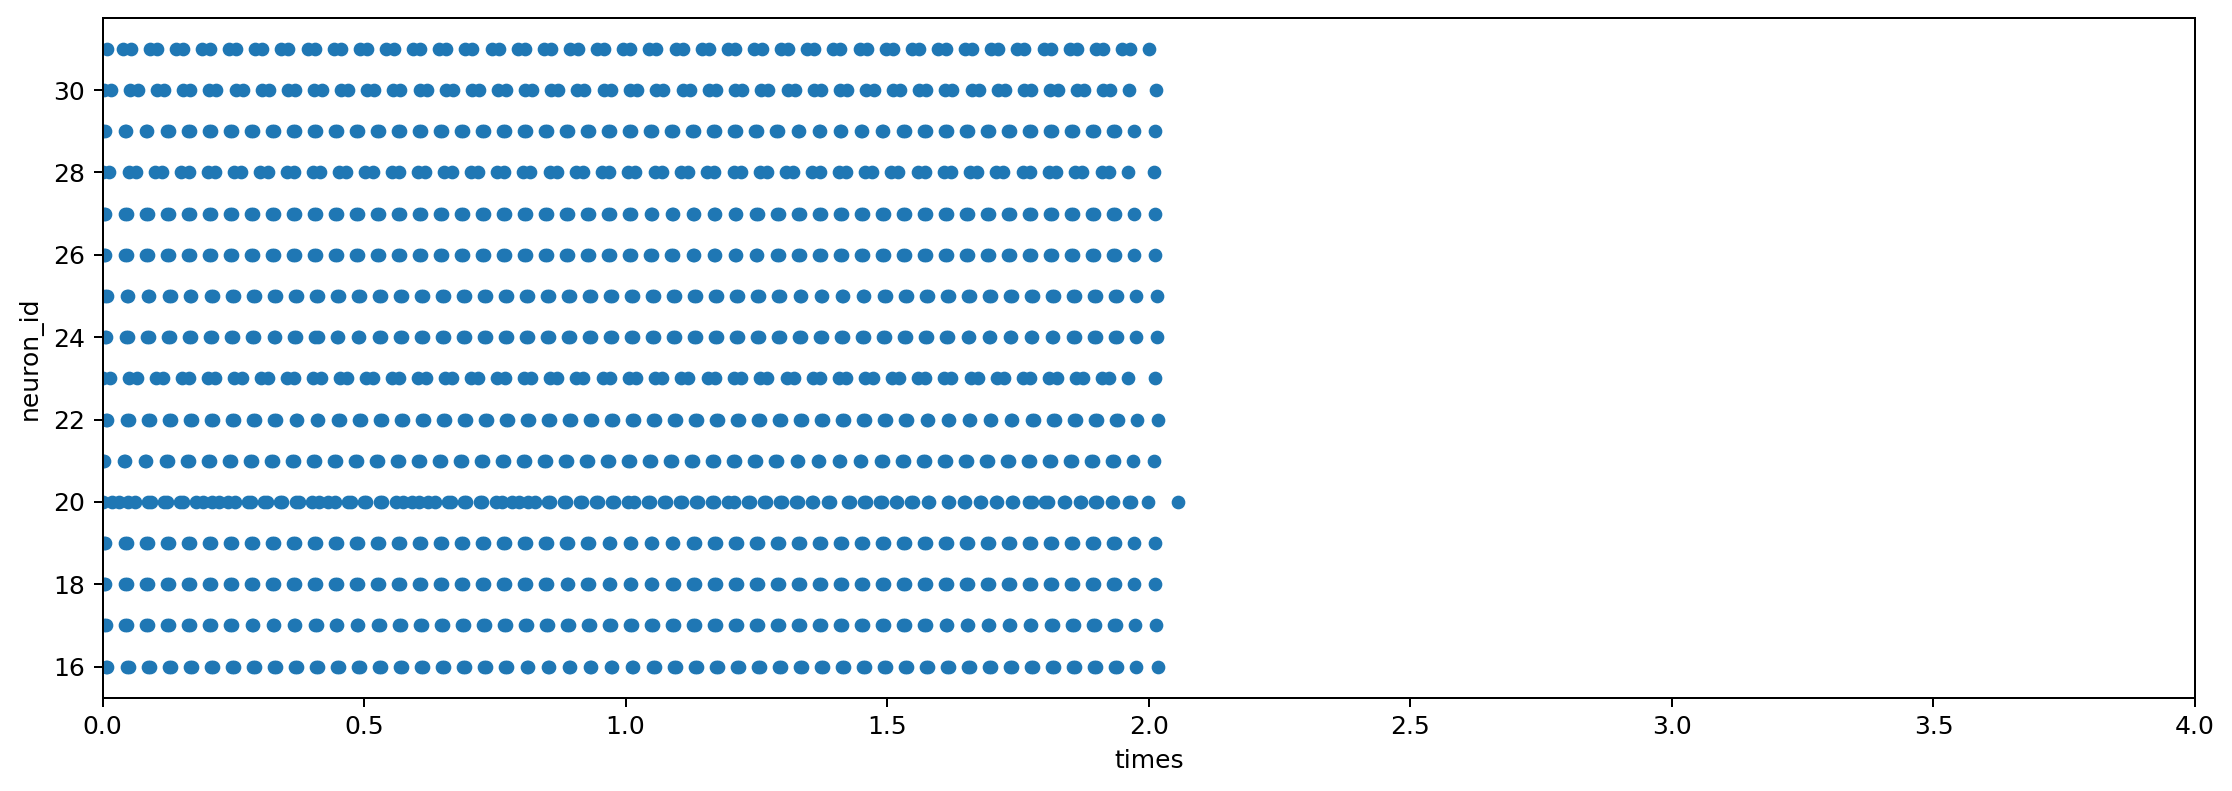

In [15]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
results_df.plot(x='times', y='neuron_id', kind='scatter', ax=ax)
plt.xlim([0,4])

(0.0, 60.0)

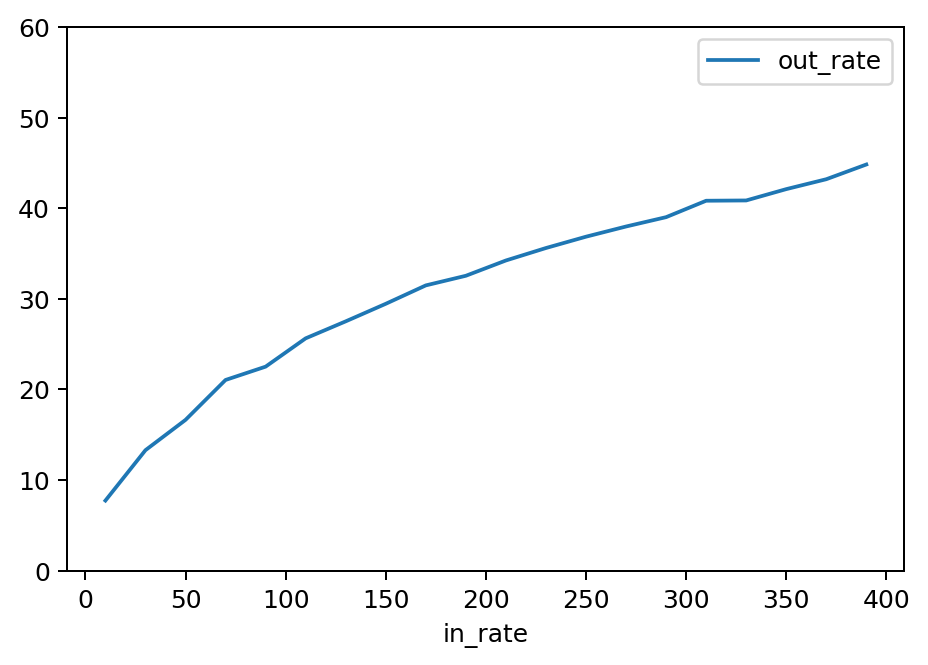

In [18]:
ff_df.plot(x='in_rate', y='out_rate', kind='line')
plt.ylim([0,60])

Q: How can you increase the gain of this network? Think topology...


### 2. Adding recurrency and self-excitation

**Step 5**: Add recurrent excitatory connections to the cluster (you can use AMPA synapses for that). Change the probability of connections (make sure you use a random seed for reproducibility)

**Step 6**: Re-do the FF curve of this network. `Q: What can you say about the gain of this network?`

**Step 7**: Make sure you provide the input for 2 seconds only then remove it. Record the population activity for 4 seconds at least. `Q: What do you observe from the raster plot and FF curve? Can you spot a problem (i.e an undesired effect) with this topology?`

In [19]:
def exc_rec_bias():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    
    #------------------------AMPA parameters----------------------#
    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 100

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 80

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 100

    #------------------------NMDA parameters----------------------#
    # first keep NMDA threshold to 0: i.e deactivate (AMPA_like) at coarse 0
    paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
    paramGroup.param_map["IF_NMDA_N"].fine_value = 0

    # Adjust weight of NMDA
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 6 
    paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 100

    # # NMDA time constant
    paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80

    # NMDA gain
    paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 5
    paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 40

    #--------------------Neuron parameters--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    return paramGroup

In [20]:
# Input firing range
in_rates = np.arange(10, 400, 50)

# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

#-----------------------Network ----------------------------#
net_gen = n.NetworkGenerator()
# Allocate neurons of excitatory cluster
neu_chip_id = 0
neu_core_id = 1
n_exc = 16
neu_ids = np.arange(16, 16 + n_exc,1)

DPI_neuron =  n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Allocate spikegen
spgen_chip_id = 0
spgen_core_id = 1
spgen_id = [0]
spikegen = n.NeuronGroup(spgen_chip_id ,spgen_core_id,spgen_id,True) 


# Connect all2all with AMPA synpase
syn_ff = n.Synapses(spikegen, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')
n.add_synapses(net_gen, syn_ff)

# Add excitatory recurrent connections
p_ee = 1
# net_gen.add_connections_from_type(DPI_neuron.neurons, DPI_neuron.neurons, dyn1.Dynapse1SynType.AMPA, conn_type='all2all', p=0.2, rand_seed=100)
syn_rec = n.Synapses(DPI_neuron, DPI_neuron, dyn1.Dynapse1SynType.AMPA, conn_type='all2all', p = p_ee)
n.add_synapses(net_gen, syn_rec)

print(f"Sanity check config:{net_gen.network}")

# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

#--------------------Set input spike train ----------------------#

# get FPGA spike_gen from model
fpga_spike_gen = model.get_fpga_spike_gen()
isi_base = 900
repeat_mode = False

#-----------------Tune biases-------------------------------------#
paramGroup = exc_rec_bias()
model.update_parameter_group(paramGroup, DPI_neuron.chip_id, DPI_neuron.core_id)


#--------------------Monitor ----------------------#

graph, filter_node, sink_node = ut.create_neuron_select_graph(model, DPI_neuron.tuple_neuron_ids)


results_df = pd.DataFrame()
ff_df_rec = pd.DataFrame(columns=['in_rate', 'out_rate'])
mon_dur = 4 # in sec
for row, rate in enumerate([100]): #in_rates
    spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, DPI_neuron.chip_id, rate, emu_dur)
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)
    
    # start gens
    fpga_spike_gen.start()

    # Start graph 
    graph.start()

    # Clear buffer
    sink_node.get_events()

    for i in range(4):
        # get spikes every 2 seconds
        time.sleep(emu_dur)
        events = sink_node.get_events()

        # process the events
        mean_rate_pop = len(events)/n_exc/(emu_dur)
        print(f"Events:{len(events)}    Mean rate:{mean_rate_pop} Hz")
        results_df = organize_results(events, results_df)

    graph.stop()
    fpga_spike_gen.stop()
    # Organize events
    # results_df = organize_results(events, results_df)
    ff_df_rec.loc[row] = [rate, mean_rate_pop]


Sanity check config:Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n26: [('C0c1s0', 'NMDA'), ('C0c1n20', 'AMPA'), ('C0c1n27', 'AMPA'), ('C0c1n29', 'AMPA'), ('C0c1n24', 'AMPA'), ('C0c1n22', 'AMPA'), ('C0c1n28', 'AMPA'), ('C0c1n26', 'AMPA'), ('C0c1n21', 'AMPA'), ('C0c1n17', 'AMPA'), ('C0c1n31', 'AMPA'), ('C0c1n19', 'AMPA'), ('C0c1n23', 'AMPA'), ('C0c1n16', 'AMPA'), ('C0c1n25', 'AMPA'), ('C0c1n18', 'AMPA'), ('C0c1n30', 'AMPA')]
C0c1n25: [('C0c1s0', 'NMDA'), ('C0c1n29', 'AMPA'), ('C0c1n23', 'AMPA'), ('C0c1n26', 'AMPA'), ('C0c1n16', 'AMPA'), ('C0c1n19', 'AMPA'), ('C0c1n27', 'AMPA'), ('C0c1n20', 'AMPA'), ('C0c1n24', 'AMPA'), ('C0c1n25', 'AMPA'), ('C0c1n31', 'AMPA'), ('C0c1n30', 'AMPA'), ('C0c1n22', 'AMPA'), ('C0c1n18', 'AMPA'), ('C0c1n21', 'AMPA'), ('C0c1n17', 'AMPA'), ('C0c1n28', 'AMPA')]
C0c1n21: [('C0c1s0', 'NMDA'), ('C0c1n17', 'AMPA'), ('C0c1n23', 'AMPA'), ('C0c1n16', 'AMPA'), ('C0c1n30', 'AMPA'), ('C0c1n22', 'AMPA'), ('C0c1n20', 'AMPA'), ('

Text(0.5, 1.0, 'P_ee = 0.1')

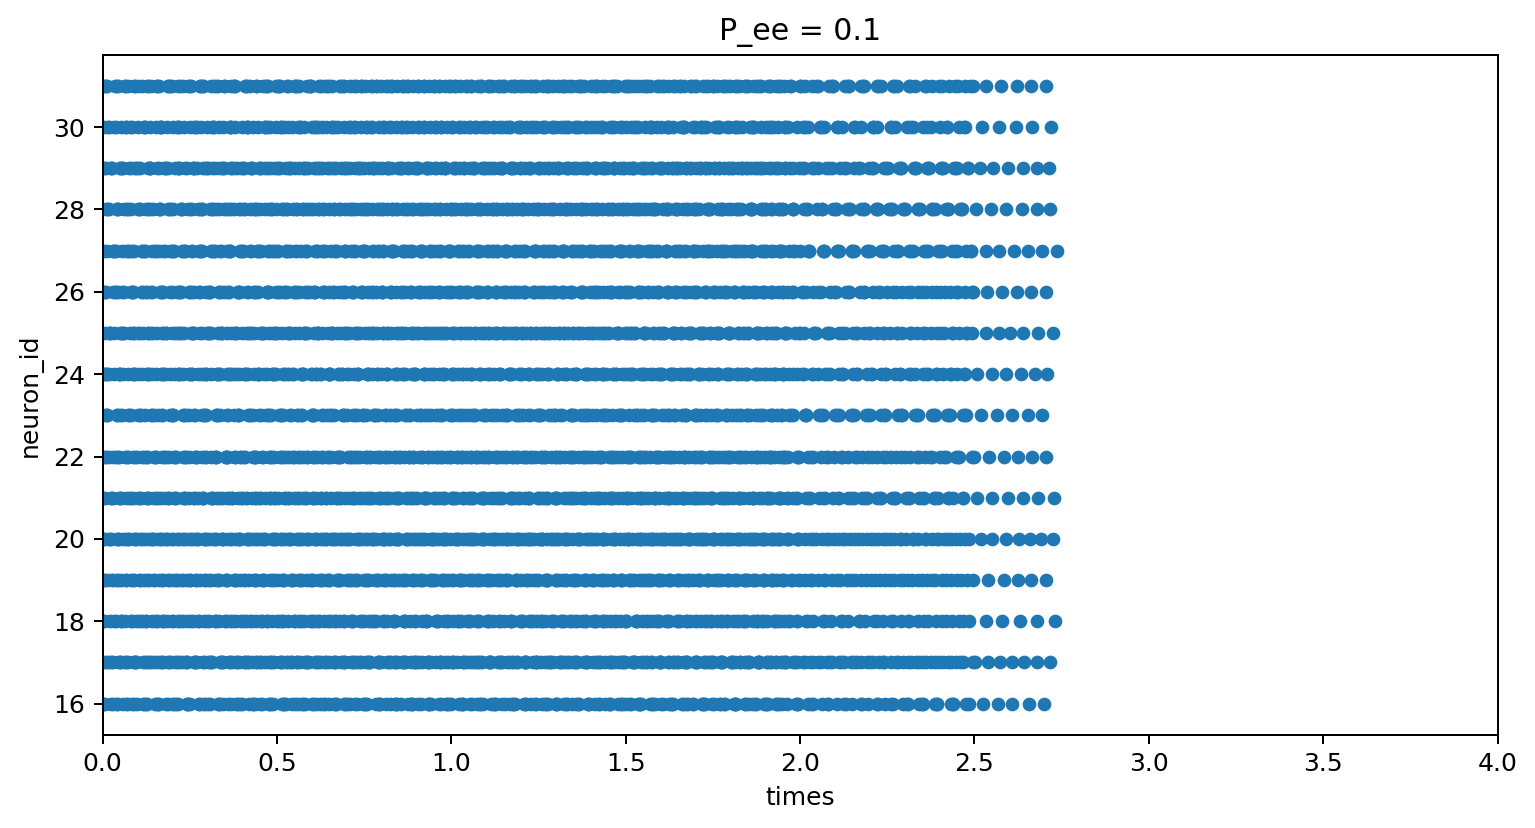

In [21]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
results_df.plot(x='times', y='neuron_id', kind='scatter', ax=ax)
plt.xlim([0,4])
plt.title("P_ee = 0.1")

### 3. Adding negative feedback via inhibition creating a balanced EI


**Step 8**: Allocate another population of neurons (n_inb = 4) on a separate core. This will form our inhibitory population.

**Step 9**: Connect excitatory population of Part 2 to inhibitory one via AMPA/NMDA synapses.

**Step 10**: Connect inhibitory population back to the excitatory population via inhibitory synapses (try both shunting and subtractive) as shown in Figure 1.i

**Step 11**: Provide the same poisson input from the previous parts to the excitatory population. 

**Step 12**: Plot FF curve and spike times. Tune the necessary parameters to achieve an excitatory/inhibitiory balance. You should observe sparse and decorrelated activity in the raster plot as illustrated in Figure 1.j.



<center>
<p>
<img src="ei_net_activity.png" alt="ei_network" style="width: 900px;">
</p>
<em> Figure 1: (i) Cluster of excitatory neurons connected with pure feedforward, recurrent excitation and feedback inhibition. (j) Raster plot o the excitatory population. (k) Mean firing rate (blue) and individual neurons response (gray) of the excitatory population. Extracted from

[Zendrikov, Solinas and Indiveri, 2022](https://www.biorxiv.org/content/10.1101/2022.10.26.513846v1)</em>

</center>

In [25]:
ff_raster_dima = np.load("single_EI_cluster_rasters/extended_1_raster_ff.npy")
rec_raster_dima = np.load("single_EI_cluster_rasters/extended_1_raster_rec.npy")


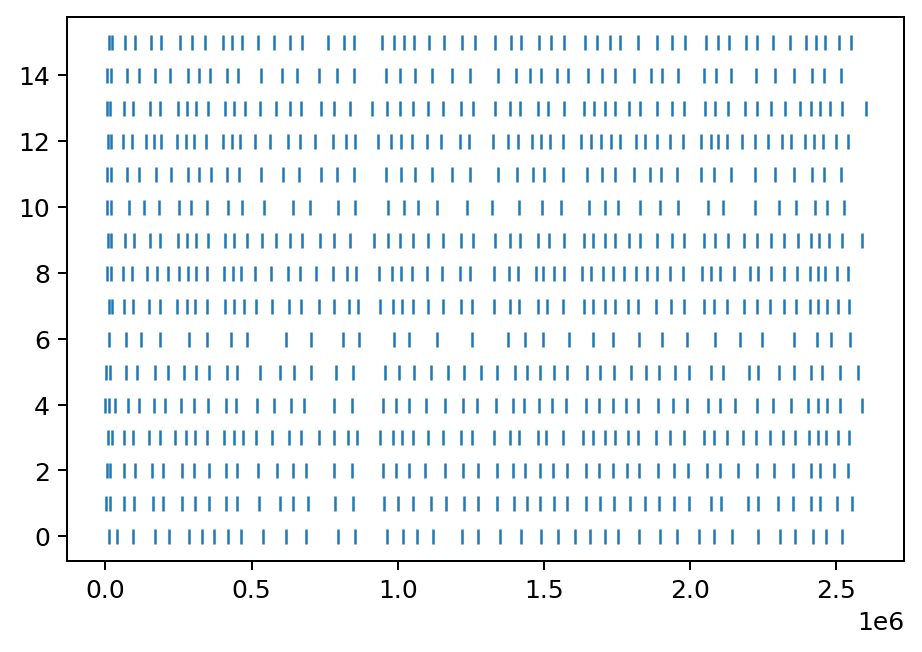

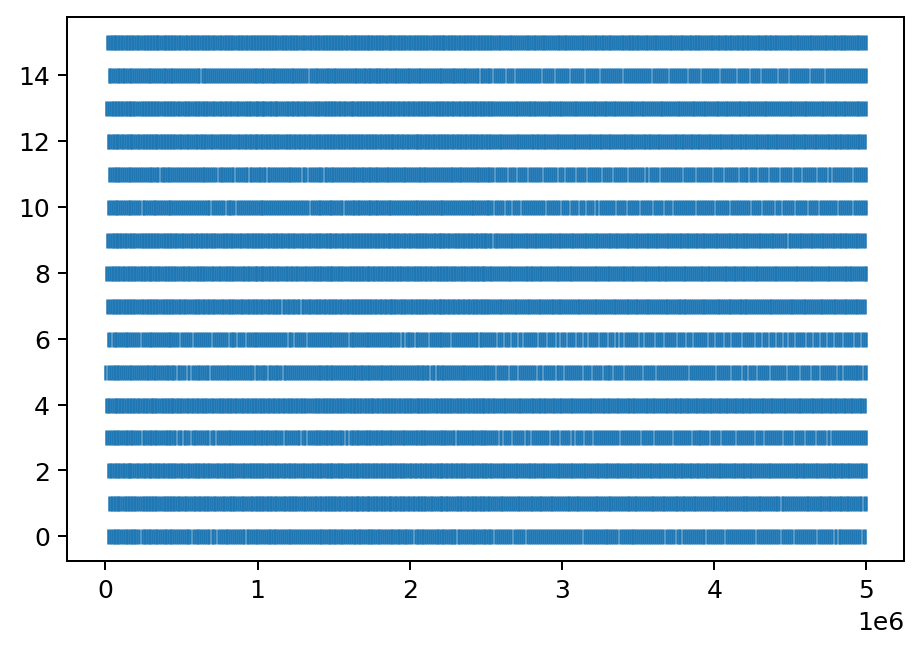

In [26]:
# ff_biases_dima
plt.plot(ff_raster_dima[:,0], ff_raster_dima[:,1], '|')
plt.figure()
plt.plot(rec_raster_dima[:,0], rec_raster_dima[:,1], '|')


In [138]:
# Some utility functions you can use
def display_model_config(model_config, chip_id, core_id, param_name=None):
    """
    Utility function to print the current configuration for a given chip_id and core_id.
    If param_name is not provided, all the parameters are displayed.
    """
    if param_name is None:  # if not none
        for bias_name in BIAS_NAMES:
            bias_coarse = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[bias_name].coarse_value
            bias_fine = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[bias_name].fine_value
            print(f"{bias_name}  Coarse:{bias_coarse}    Fine:{bias_fine}")
    else:
        bias_coarse = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[param_name].coarse_value
        bias_fine = model_config.chips[chip_id].cores[core_id].parameter_group.param_map[param_name].fine_value
        print(f"{param_name}  Coarse:{bias_coarse}    Fine:{bias_fine}")
    

In [154]:
def inh_exc_bias(paramGroup):
    # paramGroup = dyn1.Dynapse1ParameterGroup()


    #------------------------GABA_B parameters----------------------#
    # Adjust weight of GABA_B
    paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
    paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 10

    # # NMDA time constant
    paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 2
    paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

    # GABA weight
    paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 3
    paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 120

    # Gain 
    paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 2
    paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 135
    return paramGroup


def exc_inh_bias():
    paramGroup = dyn1.Dynapse1ParameterGroup()
    
    #------------------------AMPA parameters----------------------#
    # leakage of AMPA
    paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 3
    paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 100

    # gain of AMPA
    paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 6
    paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 100

    # weight of AMPA
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
    paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200

   
    #--------------------Neuron parameters--------------------------#
    # Inject current to make neuron fire
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0

    # Reduce neuron leakage
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 4
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80
    return paramGroup

In [159]:
net_gen.network

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n20: [('C0c1s0', 'NMDA'), ('C0c1n31', 'NMDA'), ('C0c1n29', 'NMDA'), ('C0c1n21', 'NMDA'), ('C0c1n26', 'NMDA'), ('C0c1n16', 'NMDA'), ('C0c1n30', 'NMDA'), ('C0c1n28', 'NMDA'), ('C0c1n22', 'NMDA'), ('C0c1n18', 'NMDA'), ('C0c1n23', 'NMDA'), ('C0c1n24', 'NMDA'), ('C0c1n27', 'NMDA'), ('C0c1n25', 'NMDA'), ('C0c1n17', 'NMDA'), ('C0c1n19', 'NMDA'), ('C0c3n103', 'GABA_B'), ('C0c3n101', 'GABA_B'), ('C0c3n100', 'GABA_B'), ('C0c3n102', 'GABA_B')]
C0c1n16: [('C0c1s0', 'NMDA'), ('C0c1n28', 'NMDA'), ('C0c1n18', 'NMDA'), ('C0c1n19', 'NMDA'), ('C0c1n22', 'NMDA'), ('C0c1n17', 'NMDA'), ('C0c1n23', 'NMDA'), ('C0c1n24', 'NMDA'), ('C0c1n20', 'NMDA'), ('C0c1n29', 'NMDA'), ('C0c1n30', 'NMDA'), ('C0c1n26', 'NMDA'), ('C0c1n31', 'NMDA'), ('C0c3n101', 'GABA_B'), ('C0c3n102', 'GABA_B'), ('C0c3n103', 'GABA_B'), ('C0c3n100', 'GABA_B')]
C0c1n21: [('C0c1s0', 'NMDA'), ('C0c1n16', 'NMDA'), ('C0c1n21', 'NMDA'), ('C0c1n28', 'NMDA')

In [171]:
# Input firing range
in_rates = np.arange(10, 400, 50)

# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

#-----------------------Network ----------------------------#
net_gen = n.NetworkGenerator()
# Allocate neurons of excitatory cluster
neu_chip_id = 0
neu_core_id = 1
n_exc = 16
neu_ids = np.arange(16, 16 + n_exc,1)

exc_pop =  n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Allocate neurons of inhibitory populatin
neu_inh_chip_id = 0
neu_inh_core_id = 3
n_inh = 4
neu_inh_ids = np.arange(100,100+n_inh,1)
inh_pop = n.NeuronGroup(neu_inh_chip_id, neu_inh_core_id, neu_inh_ids)

# Allocate spikegen
spgen_chip_id = 0
spgen_core_id = 1
spgen_id = [0]
spikegen = n.NeuronGroup(spgen_chip_id ,spgen_core_id,spgen_id,True) 


# Connect all2all with AMPA synpase
syn_inp = n.Synapses(spikegen, exc_pop, dyn1.Dynapse1SynType.NMDA, conn_type='all2all' )
n.add_synapses(net_gen, syn_inp)

syn_ei = n.Synapses(exc_pop, inh_pop, dyn1.Dynapse1SynType.AMPA, conn_type='all2all',p=1)
n.add_synapses(net_gen, syn_ei)

syn_ee = n.Synapses(exc_pop, exc_pop, dyn1.Dynapse1SynType.NMDA, conn_type='all2all', p=0.8)
n.add_synapses(net_gen, syn_ee)

syn_ie = n.Synapses(inh_pop, exc_pop, dyn1.Dynapse1SynType.GABA_B, conn_type='all2all', p=1)
n.add_synapses(net_gen, syn_ie)

# print(f"Sanity check config:{net_gen.network}")



# apply configuration
current_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(current_config)

# #--------------------Set input spike train ----------------------#

# # get FPGA spike_gen from model
fpga_spike_gen = model.get_fpga_spike_gen()
isi_base = 900
repeat_mode = False

#-----------------Tune biases-------------------------------------#
paramGroup = exc_rec_bias()
model.update_parameter_group(paramGroup, exc_pop.chip_id, exc_pop.core_id)

# paramGroup_ei = exc_inh_bias()
# model.update_parameter_group(paramGroup_ei, inh_pop.chip_id, inh_pop.core_id)
param = dyn1.Dynapse1Parameter("PS_WEIGHT_EXC_F_N", 7, 255)
model.update_single_parameter(param, inh_pop.chip_id, inh_pop.core_id)

param = dyn1.Dynapse1Parameter("NPDPIE_TAU_F_P", 4, 185)
model.update_single_parameter(param, inh_pop.chip_id, inh_pop.core_id)

param = dyn1.Dynapse1Parameter("NPDPIE_THR_F_P", 5, 46)
model.update_single_parameter(param, inh_pop.chip_id, inh_pop.core_id)

param = dyn1.Dynapse1Parameter("IF_DC_P", 0, 1)
model.update_single_parameter(param, inh_pop.chip_id, inh_pop.core_id)

param = dyn1.Dynapse1Parameter("IF_TAU1_N", 4, 53)
model.update_single_parameter(param, inh_pop.chip_id, inh_pop.core_id)


#----------------------------------------

# paramGroup = pure_ff_bias()
# model.update_parameter_group(paramGroup, exc_pop.chip_id, exc_pop.core_id)


# paramGroup_ie = inh_exc_bias(paramGroup)
# model.update_parameter_group(paramGroup_ie,  exc_pop.chip_id, exc_pop.core_id)


current_config = model.get_configuration()
display_model_config(current_config, inh_pop.chip_id, inh_pop.core_id, param_name='PS_WEIGHT_EXC_F_N')
#--------------------Monitor ----------------------#
mon_neurons  = exc_pop.tuple_neuron_ids
mon_neurons.extend(inh_pop.tuple_neuron_ids)
graph, filter_node, sink_node = ut.create_neuron_select_graph(model,inh_pop.tuple_neuron_ids )


results_df = pd.DataFrame()
ff_df_rec = pd.DataFrame(columns=['in_rate', 'out_rate'])
mon_dur = 4 # in sec
for row, rate in enumerate([100]): #in_rates
    spike_times, dev_ids, target_chips = generate_reg_sp_train(spikegen, exc_pop.chip_id, rate, emu_dur)
    ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, dev_ids, target_chips, isi_base, repeat_mode)
    
    # start gens
    fpga_spike_gen.start()

    # Start graph 
    graph.start()

    # Clear buffer
    sink_node.get_events()

    for i in range(4):
        # get spikes every 2 seconds
        time.sleep(emu_dur+2)
        events = sink_node.get_events()

        # process the events
        mean_rate_pop = len(events)/n_exc/(emu_dur)
        print(f"Events:{len(events)}    Mean rate:{mean_rate_pop} Hz")
        results_df = organize_results(events, results_df)

    graph.stop()
    fpga_spike_gen.stop()
    # Organize events
    # results_df = organize_results(events, results_df)
    ff_df_rec.loc[row] = [rate, mean_rate_pop]


PS_WEIGHT_EXC_F_N  Coarse:7    Fine:255
Events:0    Mean rate:0.0 Hz
Events:0    Mean rate:0.0 Hz
Events:0    Mean rate:0.0 Hz
Events:0    Mean rate:0.0 Hz


In [158]:
len(results_df.neuron_id.unique())

16

(0.0, 4.0)

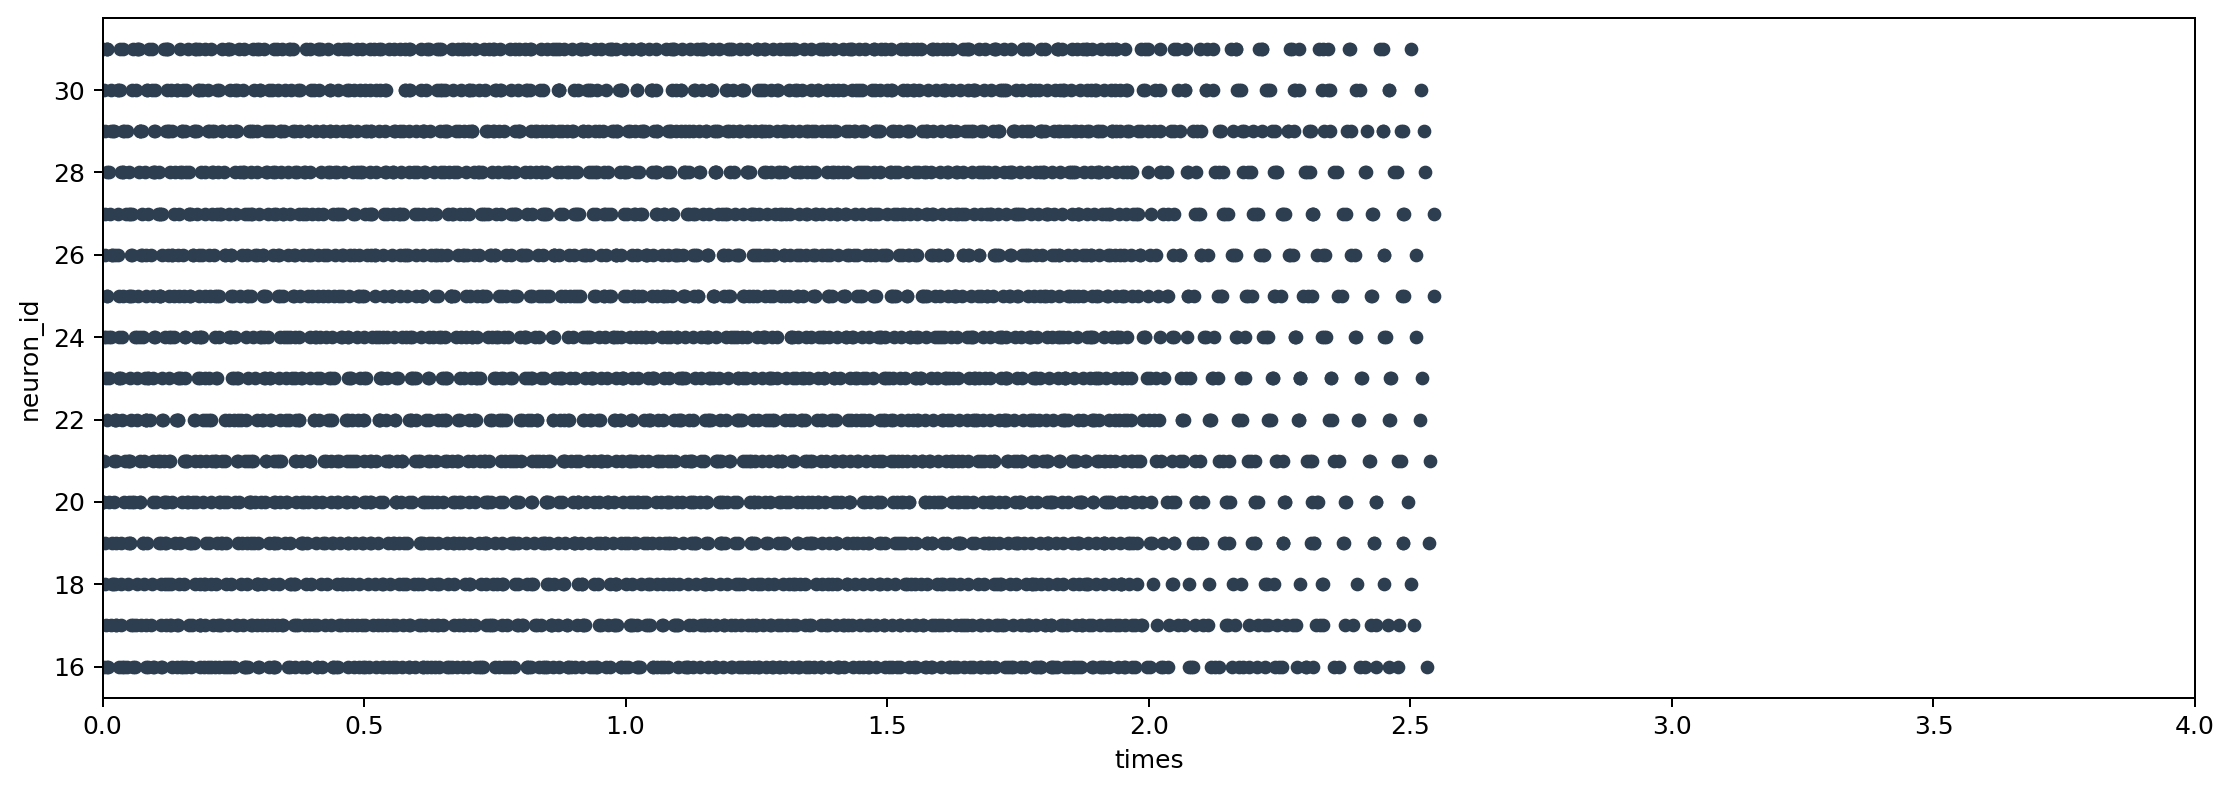

In [131]:
COLOR_DICT = {'pumpkin': '#d35400', 'midnight_blue': '#2c3e50', 'pomgrenate': '#c0392b', 'green_sea': '#16a085',
              'wisteria': '#8e44ad', 'orange': '#f39c12', 'clouds': '#7f8c8d', 'naval': '#40739e', 'purple': '#8c7ae6'}

exc_df = results_df[results_df['neuron_id'] < 100]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
exc_df.plot(x='times', y='neuron_id', kind='scatter', ax=ax, color= COLOR_DICT['midnight_blue'])


inh_df = results_df[results_df['neuron_id'] >= 100]
inh_df.plot(x='times', y='neuron_id', kind='scatter', ax=ax, color= COLOR_DICT['pumpkin'])


plt.xlim([0,4])

In [123]:
print(f"Sanity check config:{net_gen.network}")


Sanity check config:Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n28: [('C0c1s0', 'NMDA'), ('C0c1n18', 'AMPA'), ('C0c1n28', 'AMPA'), ('C0c1n17', 'AMPA'), ('C0c1n27', 'AMPA'), ('C0c1n16', 'AMPA')]
C0c1n25: [('C0c1s0', 'NMDA'), ('C0c1n21', 'AMPA'), ('C0c1n18', 'AMPA')]
C0c1n30: [('C0c1s0', 'NMDA'), ('C0c1n22', 'AMPA'), ('C0c1n21', 'AMPA'), ('C0c1n24', 'AMPA'), ('C0c1n18', 'AMPA')]
C0c1n19: [('C0c1s0', 'NMDA'), ('C0c1n31', 'AMPA'), ('C0c1n20', 'AMPA'), ('C0c1n26', 'AMPA')]
C0c1n18: [('C0c1s0', 'NMDA')]
C0c1n26: [('C0c1s0', 'NMDA'), ('C0c1n20', 'AMPA'), ('C0c1n19', 'AMPA'), ('C0c1n28', 'AMPA')]
C0c1n20: [('C0c1s0', 'NMDA'), ('C0c1n23', 'AMPA'), ('C0c1n27', 'AMPA'), ('C0c1n22', 'AMPA'), ('C0c1n17', 'AMPA'), ('C0c1n19', 'AMPA'), ('C0c1n28', 'AMPA'), ('C0c1n18', 'AMPA')]
C0c1n29: [('C0c1s0', 'NMDA'), ('C0c1n31', 'AMPA'), ('C0c1n18', 'AMPA')]
C0c1n21: [('C0c1s0', 'NMDA'), ('C0c1n23', 'AMPA'), ('C0c1n28', 'AMPA'), ('C0c1n26', 'AMPA'), ('C0c1n21',

In [105]:
net_gen = n.NetworkGenerator()

# Input firing range
in_rates = np.arange(10, 400, 50)

# set initial (proper) parameters
paramGroup = params.gen_clean_param_group()
for neu_chip_id in range(4):
    for neu_core_id in range(4):
        model.update_parameter_group(paramGroup, neu_chip_id, neu_core_id)

#-----------------------Network ----------------------------#

# Allocate neurons of excitatory cluster
neu_chip_id = 1
neu_core_id = 2
n_exc = 16
neu_ids = np.arange(16, 16 + n_exc,1)


# Allocate neurons of inhibitory populatin
neu_inh_chip_id = 1
neu_inh_core_id = 1
n_inh = 4
neu_inh_ids = np.arange(100,20+n_inh,1)

DPI_neuron_inh = n.NeuronGroup(neu_chip_id, neu_inh_core_id, neu_inh_ids)
# DPI_neuron =  n.NeuronGroup(neu_chip_id, neu_core_id, neu_ids)

# Allocate spikegen
spgen_chip_id = 0
spgen_core_id = 1
spgen_id = [0]
spikegen = n.NeuronGroup(spgen_chip_id ,spgen_core_id,spgen_id,True) 


# Connect all2all with AMPA synpase
# syn_ff = n.Synapses(spikegen, DPI_neuron, dyn1.Dynapse1SynType.NMDA, conn_type='all2all')

# Add inhibitory connections
syn_ie = n.Synapses(spikegen, DPI_neuron_inh, dyn1.Dynapse1SynType.AMPA, conn_type='all2all')
# n.add_synapses(net_gen, syn_ff)
n.add_synapses(net_gen,syn_ie)

print(net_gen.network)


The network is empty!


In [125]:
schip = 0
score = 0
sid = [1]

# select neuron population
neu_chip_id = 0
neu_core_id = 1
nid = [18,19, 20]

net_gen = n.NetworkGenerator()

spikegen = n.NeuronGroup(schip, score, sid, True)
exc_pop = n.NeuronGroup(neu_chip_id, neu_core_id, nid)
inh_pop = n.NeuronGroup(neu_chip_id, 2, nid)


# connect spikegen to neuron
syn_inp = n.Synapses(spikegen, exc_pop, dyn1.Dynapse1SynType.NMDA, conn_type='all2all', )
n.add_synapses(net_gen, syn_inp)

syn_ei = n.Synapses(exc_pop, inh_pop, dyn1.Dynapse1SynType.AMPA, conn_type='all2all',p=0.7)
n.add_synapses(net_gen, syn_ei)

syn_ee = n.Synapses(exc_pop, exc_pop, dyn1.Dynapse1SynType.NMDA, conn_type='all2all', p=0.2)
n.add_synapses(net_gen, syn_ee)

syn_ie = n.Synapses(inh_pop, exc_pop, dyn1.Dynapse1SynType.GABA_B, conn_type='all2all', p=0.7)
n.add_synapses(net_gen, syn_ie)


# print the network so you can double check (optional)
print(net_gen.network)


Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n20: [('C0c0s1', 'NMDA'), ('C0c2n18', 'GABA_B')]
C0c1n18: [('C0c0s1', 'NMDA'), ('C0c1n20', 'NMDA'), ('C0c2n20', 'GABA_B'), ('C0c2n19', 'GABA_B'), ('C0c2n18', 'GABA_B')]
C0c1n19: [('C0c0s1', 'NMDA'), ('C0c1n18', 'NMDA'), ('C0c2n19', 'GABA_B'), ('C0c2n20', 'GABA_B')]
C0c2n18: [('C0c1n18', 'AMPA'), ('C0c1n19', 'AMPA')]
C0c2n19: [('C0c1n19', 'AMPA'), ('C0c1n18', 'AMPA'), ('C0c1n20', 'AMPA')]
C0c2n20: [('C0c1n19', 'AMPA')]



In [ ]:
# samna.device.close_device(model)